In [70]:
from pathlib import Path
import sys
current_path = Path.cwd()  
project_root = current_path.parent 
sys.path.insert(0, str(project_root))

In [2]:
from src.utils.Data_Loader import data_loader
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,RobustScaler,OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer


Configurations loaded successfully


In [3]:
x_train, x_val, x_test, y_train, y_val, y_test= data_loader()

In [4]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((262642, 16), (29183, 16), (72957, 16), (262642,), (29183,), (72957,))

In [5]:
datasets = {
    "x_train": x_train,
    "x_val": x_val,
    "x_test": x_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
}

for name, ds in datasets.items():
    has_nan = ds.isnull().any() if hasattr(ds, "isnull") else False
    if hasattr(has_nan, "any"):
        has_nan = has_nan.any()
    if has_nan:
        print(f"missing values in {name}")
    else:
        print(f"no missing values in {name}")

no missing values in x_train
no missing values in x_val
no missing values in x_test
no missing values in y_train
no missing values in y_val
no missing values in y_test


In [6]:
# from scipy.stats import ks_2samp
# import pandas as pd

# # Simple drift check (KS test) for numeric features

# def drift_report(train_df, other_df, alpha=0.01):
#     numeric_cols = train_df.select_dtypes(exclude=["object", "category"]).columns
#     rows = []
#     for col in numeric_cols:
#         train_col = train_df[col].dropna()
#         other_col = other_df[col].dropna()
#         if len(train_col) == 0 or len(other_col) == 0:
#             rows.append((col, float("nan"), False))
#             continue
#         stat, pval = ks_2samp(train_col, other_col)
#         rows.append((col, pval, pval < alpha))
#     report = pd.DataFrame(rows, columns=["feature", "p_value", "drift_flag"])
#     return report.sort_values("p_value")

# print("Drift vs val (alpha=0.01)")
# print(drift_report(x_train, x_val))
# print("\nDrift vs test (alpha=0.01)")
# print(drift_report(x_train, x_test))


In [ ]:
import pandas as pd

def build_preprocessor(X):
    """
    Build preprocessing pipeline with separate handling for:
    - Continuous numeric features (log + scale)
    - Binary flags (no log, just scale)
    - Ordinal features
    - Categorical features
    """
    
    # Define original columns
    yesNoColumns = ["HasMortgage", "HasDependents", "HasCoSigner"]
    categorical_features = list(set(X.select_dtypes(include=['object'])) - set(yesNoColumns))
    
    # Original numeric features
    original_numeric = [
        'Age', 'Income', 'LoanAmount', 'CreditScore', 
        'MonthsEmployed', 'NumCreditLines', 'InterestRate', 
        'LoanTerm', 'DTIRatio'
    ]
    
    

    
    # Continuous numeric transformer (with log)
    continuous_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())  # Better for outliers
    ])
    
    # Binary transformer (NO log, just impute)

    
    # Yes/No columns
    yesNoColumns_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])
    
    # Categorical
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine all
    preprocessor = ColumnTransformer(
        transformers=[
            ('continuous', continuous_transformer, original_numeric ),
            ('yesNo', yesNoColumns_transformer, yesNoColumns),
            ('cat', categorical_transformer, categorical_features)
        ],
    )
    
    
    return preprocessor

preprocessor = build_preprocessor(x_train)
x_train_processed = preprocessor.fit_transform(x_train)
x_val_processed = preprocessor.transform(x_val)
x_test_processed = preprocessor.transform(x_test)



In [26]:
x_train_processed.shape, x_val_processed.shape, x_test_processed.shape

((262642, 28), (29183, 28), (72957, 28))

In [27]:
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight_value = num_neg / num_pos
scale_pos_weight_value

np.float64(7.629037027302297)

In [10]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [11]:
# try raw xgb
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    verbosity=0,

)
xgb_model.fit(x_train_processed, y_train, eval_set=[(x_val_processed, y_val)],verbose=False)

# Evaluate on train ,test, val
def evaluate_model(model, X, y, dataset_name="Dataset"):
    y_pred_proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_pred_proba)
    print(f"AUC on {dataset_name}: {auc:.4f}")

evaluate_model(xgb_model, x_train_processed, y_train, "Train")
evaluate_model(xgb_model, x_val_processed, y_val, "Validation")
evaluate_model(xgb_model, x_test_processed, y_test, "Test")

AUC on Train: 0.7874
AUC on Validation: 0.6650
AUC on Test: 0.6581


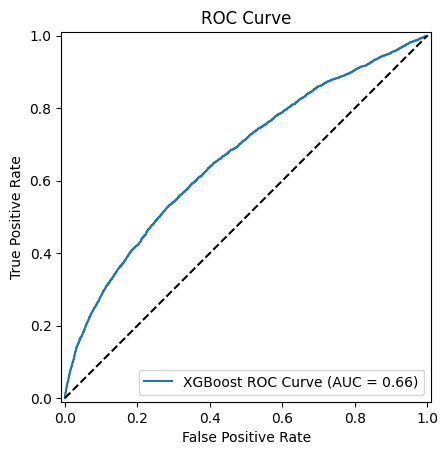

In [12]:
# roc curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(
    xgb_model,
    x_val_processed,
    y_val,
    name="XGBoost ROC Curve"
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [13]:
# catboost
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='Logloss',
    scale_pos_weight=scale_pos_weight_value,
    random_seed=42,
    
    verbose=0
)
catboost_model.fit(x_train_processed, y_train , eval_set=(x_val_processed, y_val))
evaluate_model(catboost_model, x_train_processed, y_train, "Train")
evaluate_model(catboost_model, x_val_processed, y_val, "Validation")
evaluate_model(catboost_model, x_test_processed, y_test, "Test")

AUC on Train: 0.6963
AUC on Validation: 0.6856
AUC on Test: 0.6764


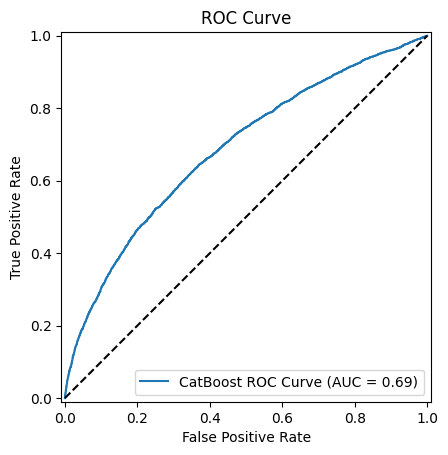

In [14]:
RocCurveDisplay.from_estimator(
    catboost_model,
    x_val_processed,
    y_val,
    name="CatBoost ROC Curve"
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [45]:
# lightgbm
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
)
lgb_model.fit(x_train_processed, y_train,
               eval_set=[(x_val_processed, y_val)],
               callbacks=[#lgb.early_stopping(100), 
                          lgb.log_evaluation(period=0)])

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [46]:
# evaluate on train ,test, val
evaluate_model(lgb_model, x_train_processed, y_train, "Train")
evaluate_model(lgb_model, x_val_processed, y_val, "Validation")
evaluate_model(lgb_model, x_test_processed, y_test, "Test")

AUC on Train: 0.7122
AUC on Validation: 0.6829
AUC on Test: 0.6738


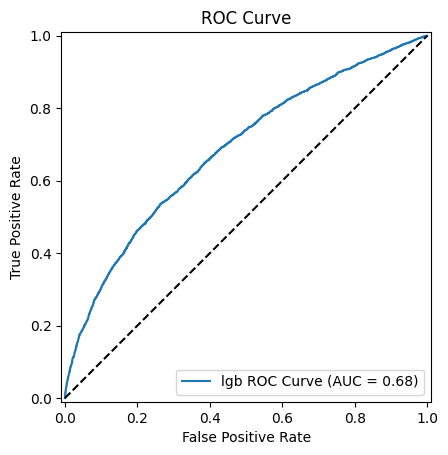

In [47]:
RocCurveDisplay.from_estimator(
    lgb_model,
    x_val_processed,
    y_val,
    name="lgb ROC Curve"
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# tunning xgb

In [18]:
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)

/home/over-mind/Downloads/SmartLend-Explainable-AI/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:

class XgbTuner:
    """Hyperparameter tuning with proper AUC calculation and CV"""
    
    def __init__(self, X_train, y_train, X_val, y_val, scale_pos_weight, use_cv=True):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scale_pos_weight = scale_pos_weight
        self.use_cv = use_cv

    def xgb_objective(self, trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "scale_pos_weight": self.scale_pos_weight,
            "device":"cuda",
            "tree_method":"hist",
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0)
        }

        if self.use_cv:
            # Use cross-validation on training data
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            cv_scores = []
            
            for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                X_tr, X_vl = self.X_train[train_idx], self.X_train[val_idx]
                y_tr, y_vl = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
                
                model = xgb.XGBClassifier(**params, verbosity=0)
                model.fit(X_tr, y_tr)
                
                probs = model.predict_proba(X_vl)[:, 1]
                cv_scores.append(roc_auc_score(y_vl, probs))
            
            return float(np.mean(cv_scores))
        else:
            # Single validation set
            model = xgb.XGBClassifier(**params, verbosity=0)
            model.fit(self.X_train, self.y_train)
            
            # CRITICAL FIX: Use predict_proba
            probs = model.predict_proba(self.X_val)[:, 1]
            return float(roc_auc_score(self.y_val, probs))
    
    def tune_xgb(self, n_trials=100):
        sampler = TPESampler(seed=42)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(func=self.xgb_objective, n_trials=n_trials, show_progress_bar=True)
        
        print(f"\nBest AUC: {study.best_trial.value:.4f}")
        return study.best_trial.params, study.best_trial.value


In [80]:
tuner_instance=XgbTuner(X_train=x_train_processed,y_train=y_train,X_val=x_val_processed,y_val=y_val,scale_pos_weight=scale_pos_weight_value)
best_params,best_score=tuner_instance.tune_xgb(n_trials=50)
print('Best auc Score from tuning:',best_score)

Best trial: 42. Best value: 0.67678: 100%|██████████| 50/50 [08:08<00:00,  9.78s/it] 


Best AUC: 0.6768
Best auc Score from tuning: 0.6767796196859406


# tunning catboost

In [47]:
class CatBoostTuner:
    """Hyperparameter tuning for CatBoost with proper AUC calculation and CV"""
    
    def __init__(self, X_train, y_train, X_val, y_val, scale_pos_weight, use_cv=True):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scale_pos_weight = scale_pos_weight
        self.use_cv = use_cv

    def catboost_objective(self, trial):
        params = {
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "random_seed": 42,
            "scale_pos_weight": self.scale_pos_weight,
            # "task_type": "GPU",
            # "devices": "0",
            "verbose": 0,
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        }
        
        # Add max_leaves only for Lossguide policy
        if params["grow_policy"] == "Lossguide":
            params["max_leaves"] = trial.suggest_int("max_leaves", 16, 64)

        if self.use_cv:
            # Use cross-validation on training data
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            cv_scores = []
            
            for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                X_tr, X_vl = self.X_train[train_idx], self.X_train[val_idx]
                y_tr, y_vl = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
                
                model = CatBoostClassifier(**params)
                model.fit(X_tr, y_tr, verbose=0)
                
                probs = model.predict_proba(X_vl)[:, 1]
                cv_scores.append(roc_auc_score(y_vl, probs))
            
            return float(np.mean(cv_scores))
        else:
            # Single validation set
            model = CatBoostClassifier(**params)
            model.fit(self.X_train, self.y_train, verbose=0)
            
            probs = model.predict_proba(self.X_val)[:, 1]
            return float(roc_auc_score(self.y_val, probs))
    
    def tune_catboost(self, n_trials=100):
        sampler = TPESampler(seed=42)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(func=self.catboost_objective, n_trials=n_trials, show_progress_bar=True)
        
        print(f"\nBest AUC: {study.best_trial.value:.4f}")
        return study.best_trial.params, study.best_trial.value

In [ ]:
catboost_tuner = CatBoostTuner(
    X_train=x_train_processed,
    y_train=y_train,
    X_val=x_val_processed,
    y_val=y_val,
    scale_pos_weight=scale_pos_weight_value
)
catboost_best_params, catboost_best_score = catboost_tuner.tune_catboost(n_trials=50)
print('Best AUC Score from CatBoost tuning:', catboost_best_score)

# tunning lgbm

In [31]:
import pandas as pd
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrames with feature names
x_train_processed = pd.DataFrame(x_train_processed, columns=feature_names, index=x_train.index)
x_val_processed = pd.DataFrame(x_val_processed, columns=feature_names, index=x_val.index)
x_test_processed = pd.DataFrame(x_test_processed, columns=feature_names, index=x_test.index)

print(f"Feature names ({len(feature_names)}):")
print(feature_names)

Feature names (28):
['continuous__Age' 'continuous__Income' 'continuous__LoanAmount'
 'continuous__CreditScore' 'continuous__MonthsEmployed'
 'continuous__NumCreditLines' 'continuous__InterestRate'
 'continuous__LoanTerm' 'continuous__DTIRatio' 'yesNo__HasMortgage'
 'yesNo__HasDependents' 'yesNo__HasCoSigner' 'cat__MaritalStatus_Divorced'
 'cat__MaritalStatus_Married' 'cat__MaritalStatus_Single'
 "cat__Education_Bachelor's" 'cat__Education_High School'
 "cat__Education_Master's" 'cat__Education_PhD'
 'cat__EmploymentType_Full-time' 'cat__EmploymentType_Part-time'
 'cat__EmploymentType_Self-employed' 'cat__EmploymentType_Unemployed'
 'cat__LoanPurpose_Auto' 'cat__LoanPurpose_Business'
 'cat__LoanPurpose_Education' 'cat__LoanPurpose_Home'
 'cat__LoanPurpose_Other']


In [ ]:
class LGBMTuner:
    """Hyperparameter tuning for LightGBM with proper AUC calculation and CV"""
    
    def __init__(self, X_train, y_train, X_val, y_val, scale_pos_weight, use_cv=True):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scale_pos_weight = scale_pos_weight
        self.use_cv = use_cv

    def lgbm_objective(self, trial):
        params = {
            "objective": "binary",
            "metric": "auc",
            "random_state": 42,
            "scale_pos_weight": self.scale_pos_weight,
            # "device": "gpu",
            # "gpu_platform_id": 0,
            # "gpu_device_id": 0,
            "verbosity": -1,
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "num_leaves": trial.suggest_int("num_leaves", 20, 150),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        }

        if self.use_cv:
            # Use cross-validation on training data
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            cv_scores = []
            
            for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                X_tr, X_vl = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                y_tr, y_vl = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
                
                model = lgb.LGBMClassifier(**params)
                model.fit(X_tr, y_tr, callbacks=[lgb.log_evaluation(period=0)])
                
                probs = model.predict_proba(X_vl)[:, 1]
                cv_scores.append(roc_auc_score(y_vl, probs))
            
            return float(np.mean(cv_scores))
        else:
            # Single validation set
            model = lgb.LGBMClassifier(**params)
            model.fit(self.X_train, self.y_train, callbacks=[lgb.log_evaluation(period=0)])
            
            probs = model.predict_proba(self.X_val)[:, 1]
            return float(roc_auc_score(self.y_val, probs))
    
    def tune_lgbm(self, n_trials=100):
        sampler = TPESampler(seed=42)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(func=self.lgbm_objective, n_trials=n_trials, show_progress_bar=True)
        
        print(f"\nBest AUC: {study.best_trial.value:.4f}")
        return study.best_trial.params, study.best_trial.value

In [41]:
lgbm_tuner = LGBMTuner(
    X_train=x_train_processed,
    y_train=y_train,
    X_val=x_val_processed,
    y_val=y_val,
    scale_pos_weight=scale_pos_weight_value
)
lgbm_best_params, lgbm_best_score = lgbm_tuner.tune_lgbm(n_trials=50)
print('Best AUC Score from LightGBM tuning:', lgbm_best_score)

Best trial: 36. Best value: 0.676826: 100%|██████████| 50/50 [06:45<00:00,  8.12s/it]


Best AUC: 0.6768
Best AUC Score from LightGBM tuning: 0.676825661858639


In [ ]:
# lightgbm
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    **n
)
lgb_model.fit(x_train_processed, y_train,
               eval_set=[(x_val_processed, y_val)],
               callbacks=[#lgb.early_stopping(100), 
                          lgb.log_evaluation(period=0)])

,boosting_type,'gbdt'
,num_leaves,55
,max_depth,3
,learning_rate,0.02012799125086722
,n_estimators,758
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.9477191936638487
,min_child_weight,0.0029608825921946715
,min_child_samples,92


In [43]:
# evaluate on train ,test, val
evaluate_model(lgb_model, x_train_processed, y_train, "Train")
evaluate_model(lgb_model, x_val_processed, y_val, "Validation")
evaluate_model(lgb_model, x_test_processed, y_test, "Test")

AUC on Train: 0.6869
AUC on Validation: 0.6854
AUC on Test: 0.6761


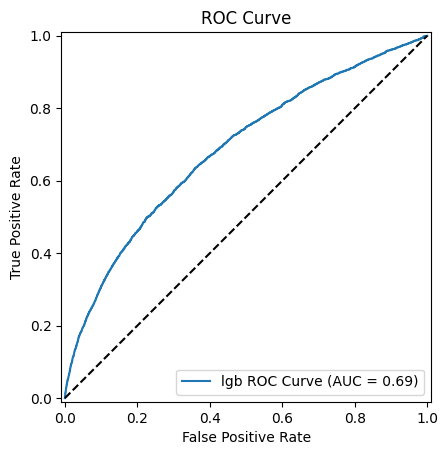

In [44]:
RocCurveDisplay.from_estimator(
    lgb_model,
    x_val_processed,
    y_val,
    name="lgb ROC Curve"
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [55]:
# Threshold tuning for catching default customers to improve business revenue
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

def find_optimal_threshold(model, X, y_true, cost_fn=10, cost_fp=1):
    """
    Find optimal threshold based on business costs.
    
    Parameters:
    - cost_fn: Cost of missing a defaulter (False Negative) - e.g., loan loss
    - cost_fp: Cost of rejecting a good customer (False Positive) - e.g., lost revenue
    
    Higher cost_fn means we want to catch more defaults (higher recall).
    """
    y_proba = model.predict_proba(X)[:, 1]
    
    thresholds = np.arange(0.1, 0.9, 0.01)
    results = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Business cost calculation
        total_cost = (fn * cost_fn) + (fp * cost_fp)
        
        # Defaults caught rate
        default_catch_rate = recall
        
        results.append({
            'threshold': thresh,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
            'total_cost': total_cost,
            'default_catch_rate': default_catch_rate
        })
    
    return pd.DataFrame(results)

# Calculate threshold metrics for the best model (lgb_model)
threshold_df = find_optimal_threshold(lgb_model, x_val_processed, y_val, cost_fn=10, cost_fp=1)
threshold_df

,threshold,precision,recall,f1,tn,fp,fn,tp,total_cost,default_catch_rate
0,0.10,0.115889,1.000000,0.207708,0,25801,0,3382,25801,1.000000
1,0.11,0.115889,1.000000,0.207708,0,25801,0,3382,25801,1.000000
2,0.12,0.115889,1.000000,0.207708,0,25801,0,3382,25801,1.000000
3,0.13,0.115897,1.000000,0.207720,2,25799,0,3382,25799,1.000000
4,0.14,0.115875,0.999704,0.207678,4,25797,1,3381,25807,0.999704
...,...,...,...,...,...,...,...,...,...,...
75,0.85,0.548780,0.013306,0.025982,25764,37,3337,45,33407,0.013306
76,0.86,0.590164,0.010645,0.020912,25776,25,3346,36,33485,0.010645
77,0.87,0.589744,0.006801,0.013446,25785,16,3359,23,33606,0.006801
78,0.88,0.592593,0.004731,0.009387,25790,11,3366,16,33671,0.004731


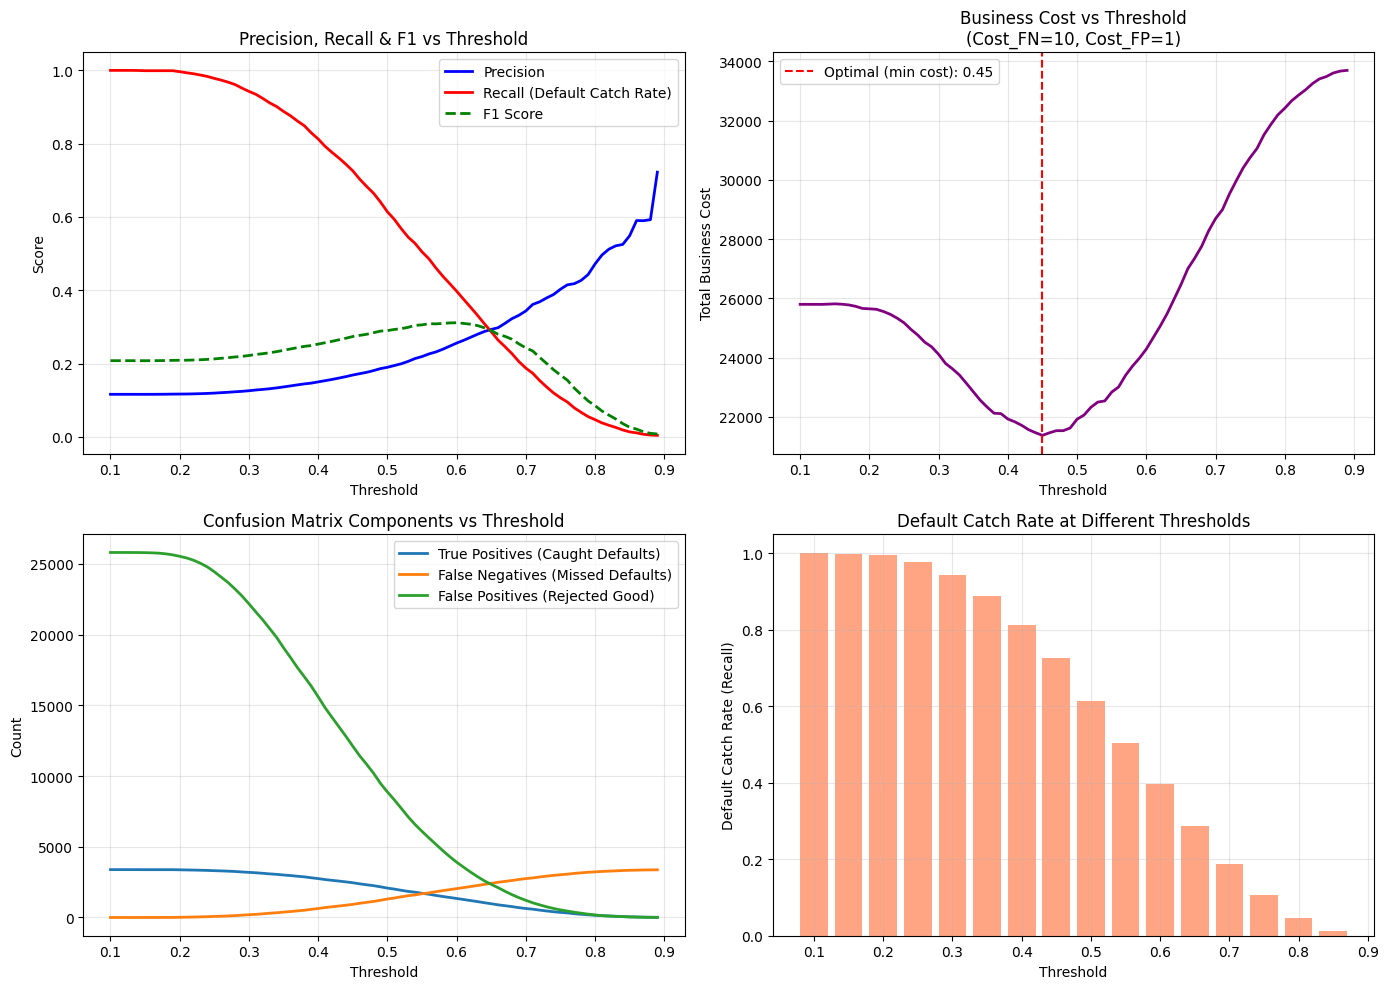


OPTIMAL THRESHOLDS FOR DIFFERENT BUSINESS OBJECTIVES

1. MINIMUM BUSINESS COST (Cost_FN=10, Cost_FP=1):
   Threshold: 0.45
   Recall (Default Catch Rate): 72.59%
   Precision: 16.86%
   Missed Defaults: 927

2. MAXIMUM F1 SCORE (Balanced):
   Threshold: 0.60
   F1 Score: 31.12%
   Recall: 39.74%
   Precision: 25.58%

3. HIGH RECALL (≥80% Default Catch Rate):
   Threshold: 0.40
   Recall: 81.28%
   Precision: 14.98%

4. VERY HIGH RECALL (≥90% Default Catch Rate):
   Threshold: 0.34
   Recall: 90.12%
   Precision: 13.34%


In [56]:
# Visualize threshold analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Precision-Recall vs Threshold
ax1 = axes[0, 0]
ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall (Default Catch Rate)', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['f1'], 'g--', label='F1 Score', linewidth=2)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision, Recall & F1 vs Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Business Cost vs Threshold
ax2 = axes[0, 1]
ax2.plot(threshold_df['threshold'], threshold_df['total_cost'], 'purple', linewidth=2)
optimal_cost_idx = threshold_df['total_cost'].idxmin()
optimal_cost_thresh = threshold_df.loc[optimal_cost_idx, 'threshold']
ax2.axvline(x=optimal_cost_thresh, color='red', linestyle='--', label=f'Optimal (min cost): {optimal_cost_thresh:.2f}')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Total Business Cost')
ax2.set_title('Business Cost vs Threshold\n(Cost_FN=10, Cost_FP=1)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix components vs Threshold
ax3 = axes[1, 0]
ax3.plot(threshold_df['threshold'], threshold_df['tp'], label='True Positives (Caught Defaults)', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['fn'], label='False Negatives (Missed Defaults)', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['fp'], label='False Positives (Rejected Good)', linewidth=2)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Count')
ax3.set_title('Confusion Matrix Components vs Threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Default Catch Rate with different thresholds
ax4 = axes[1, 1]
ax4.bar(threshold_df['threshold'][::5], threshold_df['recall'][::5], width=0.04, alpha=0.7, color='coral')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Default Catch Rate (Recall)')
ax4.set_title('Default Catch Rate at Different Thresholds')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print optimal thresholds for different objectives
print("\n" + "="*60)
print("OPTIMAL THRESHOLDS FOR DIFFERENT BUSINESS OBJECTIVES")
print("="*60)

# Minimum cost threshold
min_cost_row = threshold_df.loc[threshold_df['total_cost'].idxmin()]
print(f"\n1. MINIMUM BUSINESS COST (Cost_FN=10, Cost_FP=1):")
print(f"   Threshold: {min_cost_row['threshold']:.2f}")
print(f"   Recall (Default Catch Rate): {min_cost_row['recall']:.2%}")
print(f"   Precision: {min_cost_row['precision']:.2%}")
print(f"   Missed Defaults: {int(min_cost_row['fn'])}")

# Maximum F1 threshold
max_f1_row = threshold_df.loc[threshold_df['f1'].idxmax()]
print(f"\n2. MAXIMUM F1 SCORE (Balanced):")
print(f"   Threshold: {max_f1_row['threshold']:.2f}")
print(f"   F1 Score: {max_f1_row['f1']:.2%}")
print(f"   Recall: {max_f1_row['recall']:.2%}")
print(f"   Precision: {max_f1_row['precision']:.2%}")

# High recall threshold (catch 80% of defaults)
high_recall_df = threshold_df[threshold_df['recall'] >= 0.80]
if not high_recall_df.empty:
    high_recall_row = high_recall_df.loc[high_recall_df['precision'].idxmax()]
    print(f"\n3. HIGH RECALL (≥80% Default Catch Rate):")
    print(f"   Threshold: {high_recall_row['threshold']:.2f}")
    print(f"   Recall: {high_recall_row['recall']:.2%}")
    print(f"   Precision: {high_recall_row['precision']:.2%}")

# Very high recall threshold (catch 90% of defaults)
very_high_recall_df = threshold_df[threshold_df['recall'] >= 0.90]
if not very_high_recall_df.empty:
    very_high_recall_row = very_high_recall_df.loc[very_high_recall_df['precision'].idxmax()]
    print(f"\n4. VERY HIGH RECALL (≥90% Default Catch Rate):")
    print(f"   Threshold: {very_high_recall_row['threshold']:.2f}")
    print(f"   Recall: {very_high_recall_row['recall']:.2%}")
    print(f"   Precision: {very_high_recall_row['precision']:.2%}")

In [60]:
# Apply optimal threshold and show final classification report
CHOSEN_THRESHOLD = .40

y_val_proba = lgb_model.predict_proba(x_val_processed)[:, 1]
y_val_pred_optimized = (y_val_proba >= CHOSEN_THRESHOLD).astype(int)
y_val_pred_default = (y_val_proba >= 0.5).astype(int)

print(f"COMPARISON: Default Threshold (0.5) vs Optimized Threshold ({CHOSEN_THRESHOLD:.2f})")
print("="*70)

print("\n📊 Default Threshold (0.5):")
print(classification_report(y_val, y_val_pred_default))
cm_default = confusion_matrix(y_val, y_val_pred_default)
print(f"Confusion Matrix:\n{cm_default}")

print(f"\n📊 Optimized Threshold ({CHOSEN_THRESHOLD:.2f}):")
print(classification_report(y_val, y_val_pred_optimized))
cm_optimized = confusion_matrix(y_val, y_val_pred_optimized)
print(f"Confusion Matrix:\n{cm_optimized}")

# Business impact comparison
fn_default = cm_default[1, 0]
fn_optimized = cm_optimized[1, 0]
defaults_saved = fn_default - fn_optimized

print("\n" + "="*70)
print("💰 BUSINESS IMPACT")
print("="*70)
print(f"Missed defaults with 0.5 threshold: {fn_default}")
print(f"Missed defaults with {CHOSEN_THRESHOLD:.2f} threshold: {fn_optimized}")
print(f"Additional defaults caught: {defaults_saved} ({defaults_saved/fn_default*100:.1f}% improvement)" if fn_default > 0 else "")

COMPARISON: Default Threshold (0.5) vs Optimized Threshold (0.40)

📊 Default Threshold (0.5):
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77     25801
         1.0       0.19      0.61      0.29      3382

    accuracy                           0.65     29183
   macro avg       0.56      0.64      0.53     29183
weighted avg       0.84      0.65      0.71     29183

Confusion Matrix:
[[16925  8876]
 [ 1305  2077]]

📊 Optimized Threshold (0.40):
              precision    recall  f1-score   support

         0.0       0.94      0.40      0.56     25801
         1.0       0.15      0.81      0.25      3382

    accuracy                           0.44     29183
   macro avg       0.55      0.60      0.40     29183
weighted avg       0.85      0.44      0.52     29183

Confusion Matrix:
[[10199 15602]
 [  633  2749]]

💰 BUSINESS IMPACT
Missed defaults with 0.5 threshold: 1305
Missed defaults with 0.40 threshold: 633
Additional defaults ca

In [69]:
# Apply optimal threshold and show final classification report
CHOSEN_THRESHOLD = .45

y_val_proba = lgb_model.predict_proba(x_test_processed)[:, 1]
y_val_pred_optimized = (y_val_proba >= CHOSEN_THRESHOLD).astype(int)
y_val_pred_default = (y_val_proba >= 0.5).astype(int)

print(f"COMPARISON: Default Threshold (0.5) vs Optimized Threshold ({CHOSEN_THRESHOLD:.2f})")
print("="*70)

print("\n📊 Default Threshold (0.5):")
print(classification_report(y_test, y_val_pred_default))
cm_default = confusion_matrix(y_test, y_val_pred_default)
print(f"Confusion Matrix:\n{cm_default}")

print(f"\n📊 Optimized Threshold ({CHOSEN_THRESHOLD:.2f}):")
print(classification_report(y_test, y_val_pred_optimized))
cm_optimized = confusion_matrix(y_test, y_val_pred_optimized)
print(f"Confusion Matrix:\n{cm_optimized}")

# Business impact comparison
fn_default = cm_default[1, 0]
fn_optimized = cm_optimized[1, 0]
defaults_saved = fn_default - fn_optimized

print("\n" + "="*70)
print("💰 BUSINESS IMPACT")
print("="*70)
print(f"Missed defaults with 0.5 threshold: {fn_default}")
print(f"Missed defaults with {CHOSEN_THRESHOLD:.2f} threshold: {fn_optimized}")
print(f"Additional defaults caught: {defaults_saved} ({defaults_saved/fn_default*100:.1f}% improvement)" if fn_default > 0 else "")

COMPARISON: Default Threshold (0.5) vs Optimized Threshold (0.45)

📊 Default Threshold (0.5):
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77     64502
         1.0       0.19      0.60      0.29      8455

    accuracy                           0.65     72957
   macro avg       0.56      0.63      0.53     72957
weighted avg       0.84      0.65      0.72     72957

Confusion Matrix:
[[42666 21836]
 [ 3409  5046]]

📊 Optimized Threshold (0.45):
              precision    recall  f1-score   support

         0.0       0.93      0.54      0.68     64502
         1.0       0.17      0.71      0.27      8455

    accuracy                           0.56     72957
   macro avg       0.55      0.62      0.48     72957
weighted avg       0.85      0.56      0.64     72957

Confusion Matrix:
[[34750 29752]
 [ 2459  5996]]

💰 BUSINESS IMPACT
Missed defaults with 0.5 threshold: 3409
Missed defaults with 0.45 threshold: 2459
Additional defaults c